<h2 align="center" style="color:blue">Model Evaluation</h2>

In [1]:
# Import necessary libraries
from imports import *

In [2]:
# Load Best Model (Logistic Regression)
best_model_logistic = load("../outputs/models/best_model_logistic.pkl")

# Load datasets
X_train = pd.read_parquet("../data/processed/final_X_smt_train.parquet")
y_train = pd.read_parquet("../data/processed/final_y_smt_train.parquet").squeeze()  # convert to Series

X_test = pd.read_parquet("../data/processed/final_model_X_test.parquet")
y_test = pd.read_parquet("../data/processed/final_model_y_test.parquet").squeeze()  # convert to Series

# Load best parameters
best_params_logistic = load("../outputs/models/best_params_logistic.pkl")

# Load preprocessing objects
scaler = load("../outputs/models/minmax_scaler.pkl")
cols_to_scale = load("../outputs/models/cols_to_scale.pkl")

## Model Evaluation : ROC/AUC

In [3]:
# --- Predict class labels on test data ---
y_pred = best_model_logistic.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     11423
           1       0.56      0.94      0.70      1074

    accuracy                           0.93     12497
   macro avg       0.78      0.94      0.83     12497
weighted avg       0.96      0.93      0.94     12497



In [4]:
# --- Compute predicted probabilities for the positive class ---
probabilities = best_model_logistic.predict_proba(X_test)[:,1]

# --- Calculate ROC curve metrics: False Positive Rate, True Positive Rate, Thresholds ---
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
fpr[:5], tpr[:5], thresholds[:5]

(array([0.        , 0.        , 0.        , 0.00008754, 0.00008754]),
 array([0.        , 0.0009311 , 0.16014898, 0.16014898, 0.17690875]),
 array([2.        , 1.        , 0.99946644, 0.99945476, 0.99933229]))

In [5]:
# --- Compute AUC (Area Under ROC Curve) ---
area = auc(fpr, tpr)
area

0.9836731277074856

### Model Evaluation: ROC Curve & AUC Score

To evaluate the discriminative power of the final Logistic Regression model, I generated the **Receiver Operating Characteristic (ROC)** curve and computed the **Area Under the Curve (AUC)**.

The AUC summarizes this performance into a single number between **0.5 and 1.0**.

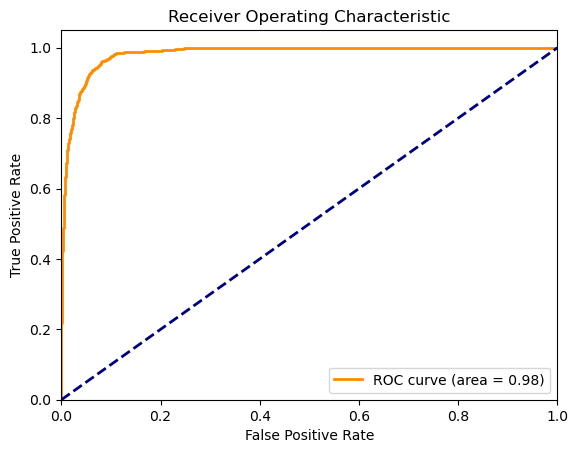

In [6]:
# --- Plot ROC Curve ---
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("../outputs/figures/roc_auc_curve.png", dpi=300)
plt.show()

An AUC of **0.98** clearly indicates that the Logistic Regression model is highly effective at ranking customers by risk.

This reinforces earlier findings, the tuned Logistic Regression model provides:

* Very strong **recall on the default class (94%)**
* Acceptable **precision (56%)**
* High explainability
* And now, **near-perfect discrimination power (AUC ≈ 0.98)**

This performance comfortably meets the business requirements.

## Model Evaluation : Rankordering, KS statistic, Gini coeff

In [10]:
probabilities

array([0.53143953, 0.0000116 , 0.00557854, ..., 0.00232825, 0.83594118,
       0.58778622])

In [14]:
probabilities = best_model_logistic.predict_proba(X_test)[:,1]
probabilities

array([0.53143953, 0.0000116 , 0.00557854, ..., 0.00232825, 0.83594118,
       0.58778622])

In [9]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
np.set_printoptions(suppress=True)

df_eval = pd.DataFrame({
    'Default Truth': y_test,
    'Default Probability': probabilities
})
df_eval.head(3)

,Default Truth,Default Probability
0,0,0.531
1,0,0.000
2,0,0.006


In [12]:
df_eval['Decile'] = pd.qcut(df_eval['Default Probability'], 10, labels=False, duplicates='drop')
df_eval.head(3)

,Default Truth,Default Probability,Decile
0,0,0.531,8
1,0,0.000,2
2,0,0.006,6


In [16]:
df_eval[df_eval.Decile==8]['Default Probability'].describe()

count   1250.000
mean       0.485
std        0.183
min        0.212
25%        0.316
50%        0.467
75%        0.641
max        0.820
Name: Default Probability, dtype: float64

In [17]:
df_decile = df_eval.groupby('Decile').apply(lambda x: pd.Series({
    'Minimum Probability': x['Default Probability'].min(),
    'Maximum Probability': x['Default Probability'].max(),
    'Events': x['Default Truth'].sum(),
    'Non-events': x['Default Truth'].count() - x['Default Truth'].sum(),    
}))
df_decile.reset_index(inplace=True)
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events
0,0,0.000,0.000,0.000,1250.000
1,1,0.000,0.000,0.000,1250.000
2,2,0.000,0.000,0.000,1249.000
3,3,0.000,0.000,0.000,1250.000
4,4,0.000,0.001,0.000,1250.000
5,5,0.001,0.004,0.000,1249.000
6,6,0.004,0.029,5.000,1245.000
7,7,0.029,0.212,11.000,1238.000
8,8,0.212,0.820,159.000,1091.000
9,9,0.820,1.000,899.000,351.000


In [18]:
df_decile['Event Rate'] = df_decile['Events']*100 / (df_decile['Events']+df_decile['Non-events'])
df_decile['Non-event Rate'] = df_decile['Non-events']*100 / (df_decile['Events']+df_decile['Non-events'])
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate
0,0,0.000,0.000,0.000,1250.000,0.000,100.000
1,1,0.000,0.000,0.000,1250.000,0.000,100.000
2,2,0.000,0.000,0.000,1249.000,0.000,100.000
3,3,0.000,0.000,0.000,1250.000,0.000,100.000
4,4,0.000,0.001,0.000,1250.000,0.000,100.000
5,5,0.001,0.004,0.000,1249.000,0.000,100.000
6,6,0.004,0.029,5.000,1245.000,0.400,99.600
7,7,0.029,0.212,11.000,1238.000,0.881,99.119
8,8,0.212,0.820,159.000,1091.000,12.720,87.280
9,9,0.820,1.000,899.000,351.000,71.920,28.080


In [19]:
df_decile = df_decile.sort_values(by='Decile', ascending=False).reset_index(drop=True)
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate
0,9,0.820,1.000,899.000,351.000,71.920,28.080
1,8,0.212,0.820,159.000,1091.000,12.720,87.280
2,7,0.029,0.212,11.000,1238.000,0.881,99.119
3,6,0.004,0.029,5.000,1245.000,0.400,99.600
4,5,0.001,0.004,0.000,1249.000,0.000,100.000
5,4,0.000,0.001,0.000,1250.000,0.000,100.000
6,3,0.000,0.000,0.000,1250.000,0.000,100.000
7,2,0.000,0.000,0.000,1249.000,0.000,100.000
8,1,0.000,0.000,0.000,1250.000,0.000,100.000
9,0,0.000,0.000,0.000,1250.000,0.000,100.000


In [20]:
df_decile['Cum Events'] =  df_decile['Events'].cumsum()
df_decile['Cum Non-events'] =  df_decile['Non-events'].cumsum()
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events
0,9,0.820,1.000,899.000,351.000,71.920,28.080,899.000,351.000
1,8,0.212,0.820,159.000,1091.000,12.720,87.280,1058.000,1442.000
2,7,0.029,0.212,11.000,1238.000,0.881,99.119,1069.000,2680.000
3,6,0.004,0.029,5.000,1245.000,0.400,99.600,1074.000,3925.000
4,5,0.001,0.004,0.000,1249.000,0.000,100.000,1074.000,5174.000
5,4,0.000,0.001,0.000,1250.000,0.000,100.000,1074.000,6424.000
6,3,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,7674.000
7,2,0.000,0.000,0.000,1249.000,0.000,100.000,1074.000,8923.000
8,1,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,10173.000
9,0,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,11423.000


In [21]:
df_decile['Cum Event Rate'] = df_decile['Cum Events'] * 100 / df_decile['Events'].sum()
df_decile['Cum Non-event Rate'] = df_decile['Cum Non-events']*100 / df_decile['Non-events'].sum()
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events,Cum Event Rate,Cum Non-event Rate
0,9,0.820,1.000,899.000,351.000,71.920,28.080,899.000,351.000,83.706,3.073
1,8,0.212,0.820,159.000,1091.000,12.720,87.280,1058.000,1442.000,98.510,12.624
2,7,0.029,0.212,11.000,1238.000,0.881,99.119,1069.000,2680.000,99.534,23.461
3,6,0.004,0.029,5.000,1245.000,0.400,99.600,1074.000,3925.000,100.000,34.361
4,5,0.001,0.004,0.000,1249.000,0.000,100.000,1074.000,5174.000,100.000,45.295
5,4,0.000,0.001,0.000,1250.000,0.000,100.000,1074.000,6424.000,100.000,56.237
6,3,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,7674.000,100.000,67.180
7,2,0.000,0.000,0.000,1249.000,0.000,100.000,1074.000,8923.000,100.000,78.114
8,1,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,10173.000,100.000,89.057
9,0,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,11423.000,100.000,100.000


In [22]:
df_decile['KS'] = abs(df_decile['Cum Event Rate'] - df_decile['Cum Non-event Rate'])
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events,Cum Event Rate,Cum Non-event Rate,KS
0,9,0.820,1.000,899.000,351.000,71.920,28.080,899.000,351.000,83.706,3.073,80.633
1,8,0.212,0.820,159.000,1091.000,12.720,87.280,1058.000,1442.000,98.510,12.624,85.887
2,7,0.029,0.212,11.000,1238.000,0.881,99.119,1069.000,2680.000,99.534,23.461,76.073
3,6,0.004,0.029,5.000,1245.000,0.400,99.600,1074.000,3925.000,100.000,34.361,65.639
4,5,0.001,0.004,0.000,1249.000,0.000,100.000,1074.000,5174.000,100.000,45.295,54.705
5,4,0.000,0.001,0.000,1250.000,0.000,100.000,1074.000,6424.000,100.000,56.237,43.763
6,3,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,7674.000,100.000,67.180,32.820
7,2,0.000,0.000,0.000,1249.000,0.000,100.000,1074.000,8923.000,100.000,78.114,21.886
8,1,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,10173.000,100.000,89.057,10.943
9,0,0.000,0.000,0.000,1250.000,0.000,100.000,1074.000,11423.000,100.000,100.000,0.000


In [31]:
df_decile.to_excel("../outputs/tables/df_decile.xlsx", index=False)
print("Saved df_decile as Excel.")

Saved df_decile as Excel.


To assess whether rank ordering is followed, we should look at whether higher deciles (those with higher predicted probabilities) have higher event rates compared to lower deciles. Rank ordering means that as you move from the top decile to the bottom decile, the event rate should generally decrease.

Non-Events - termed as good (customers) who do not default. Events - termed as bad (customers) who default.

Events and Non-Events terms are interchanged based on usecase to usecase.

eg: for marketing usecase, which customer to reach out (who will take loan based on offers) will be events - here it will termed as good, and the customers who will not take loans will be non-events (bad).

**Insights from the Decile Table**

1. Top Deciles

* The first decile (Decile 9) has a high event rate of 72.00% and a non-event rate of 28.00%. This indicates that the model is highly confident in predicting events in this decile.
* The second decile (Decile 8) also shows a significant event rate of 12.72%, with a cumulative event rate reaching 98.6%.

2. Middle Deciles:

* Deciles 7 and 6 show a significant drop in event rates

3. Lower Deciles:

* Deciles 5 to 0 show zero events, with all predictions being non-events. These deciles collectively have a non-event rate of 100%.

4. KS Statistic:

* The KS statistic, which is the maximum difference between cumulative event rates and cumulative non-event rates, is highest at Decile 8 with a value of 85.98%. This suggests that the model performs best at distinguishing between events and non-events up to this decile.

* The KS value gradually decreases in the following deciles, indicating a decrease in model performance for distinguishing between events and non-events.

**KS Value**

The highest KS value is 85.98%, found at Decile 8. This indicates that the model's performance in distinguishing between events and non-events is most significant at this decile. (If KS is in top 3 decile and score above 40, it is considered a good predictive model.)

In [23]:
gini_coefficient = 2 * area - 1

print("AUC:", area)
print("Gini Coefficient:", gini_coefficient)

AUC: 0.9836731277074856
Gini Coefficient: 0.9673462554149712


AUC of 0.98: The model is very good at distinguishing between events and non-events.

Gini coefficient of 0.96: This further confirms that the model is highly effective in its predictions, with almost perfect rank ordering capability.

The Gini coefficient ranges from -1 to 1, where a value closer to 1 signifies a perfect model, 0 indicates a model with no discriminative power, and -1 signifies a perfectly incorrect model.

#### Finalize The Model and Visualize Feature Importance

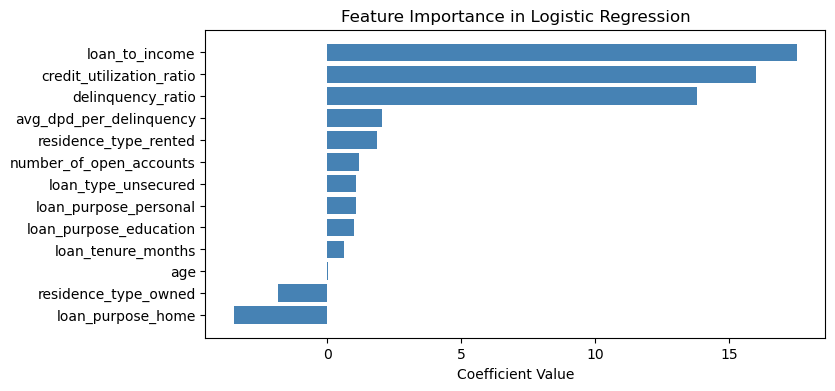

In [24]:
final_model = best_model_logistic

feature_importance = final_model.coef_[0]

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.savefig("../outputs/figures/Logistic_regression_feature_importance.png", dpi=300)
plt.show()

### Save the Model

In [25]:
X_test.head(2)

,age,loan_tenure_months,number_of_open_accounts,credit_utilization_ratio,loan_to_income,delinquency_ratio,avg_dpd_per_delinquency,residence_type_owned,residence_type_rented,loan_purpose_education,loan_purpose_home,loan_purpose_personal,loan_type_unsecured
0,0.346,0.755,0.333,0.990,0.550,0.000,0.000,1,0,0,1,0,0
1,0.481,0.226,1.000,0.323,0.220,0.000,0.000,1,0,1,0,0,0


In [26]:
X_test.columns

Index(['age', 'loan_tenure_months', 'number_of_open_accounts',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency', 'residence_type_owned',
       'residence_type_rented', 'loan_purpose_education', 'loan_purpose_home',
       'loan_purpose_personal', 'loan_type_unsecured'],
      dtype='object')

In [27]:
cols_to_scale

Index(['age', 'number_of_dependants', 'years_at_current_address', 'zipcode',
       'sanction_amount', 'processing_fee', 'gst', 'net_disbursement',
       'loan_tenure_months', 'principal_outstanding',
       'bank_balance_at_application', 'number_of_open_accounts',
       'number_of_closed_accounts', 'enquiry_count',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency'],
      dtype='object')

In [28]:
X_train.columns

Index(['age', 'loan_tenure_months', 'number_of_open_accounts',
       'credit_utilization_ratio', 'loan_to_income', 'delinquency_ratio',
       'avg_dpd_per_delinquency', 'residence_type_owned',
       'residence_type_rented', 'loan_purpose_education', 'loan_purpose_home',
       'loan_purpose_personal', 'loan_type_unsecured'],
      dtype='object')

### Export Model

In [29]:
model_data = {
    'model': final_model,
    'features': X_train.columns,
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}
dump(model_data, '../artifacts/model_data.joblib')

['../artifacts/model_data.joblib']

In [30]:
final_model.coef_, final_model.intercept_

(array([[ 0.00733101,  0.63503198,  1.18446785, 15.98924769, 17.52993107,
         13.77146291,  2.04997912, -1.8443648 ,  1.85624234,  1.00303816,
         -3.49927009,  1.06401495,  1.06401495]]),
 array([-20.88243083]))